In [247]:
import pandas as pd

In [248]:
center=pd.read_excel('health_center.xlsx')
center=center.rename(columns={'TimeFrame':'Year','Data':'Health Center'})
center=center[['Location','Year','Health Center']]
center.set_index('Location', inplace=True)
center=center.loc[['Riverside','San Bernardino']]
center=center.reset_index()
center=center[['Year','Health Center']]

In [249]:
e='econedu.csv'
ed=pd.read_csv(e)

In [250]:
ed1=ed[['Year','Median Household Income','Unemployment Rate']]

In [251]:
cpov= 'EconomyChild_Poverty.csv'
ec=pd.read_csv(cpov)

In [252]:
ec['Year']=pd.to_datetime(ec['Year']).dt.year

In [253]:
ehose='EconomyHousing_Affordability.csv'
eh=pd.read_csv(ehose)

In [254]:
eh['Year']=pd.to_datetime(eh['Year']).dt.year

In [255]:
grace='gender_race.csv'
g=pd.read_csv(grace)


In [256]:
g1=g[['School Year Ending','Gender','Race/Ethnicity','Cohort Students','Cohort Graduates','Cohort Graduation Rate']]

In [257]:
g1['School Year Ending']=pd.to_datetime(g1['School Year Ending']).dt.year

C:\Users\Kevin Bryson\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [258]:
g2=g1.rename(columns={'School Year Ending':'Year'})

In [259]:
hi='Health_Insurance.csv'
h=pd.read_csv(hi)

In [260]:
h['YEAR']=pd.to_datetime(h['YEAR']).dt.year

In [261]:
h.rename(columns={'YEAR':'Year'}, inplace='True')

In [262]:
from functools import reduce

In [263]:
dfs= [center,ed1, ec, eh, g2,h]
matrix= reduce(lambda left, right: pd.merge(left, right, on='Year'), dfs)

In [264]:
matrix1=matrix.rename(columns={'USA_x':'USA_poverty','CA_x':'CA_Poverty','SBC_x':'Poverty','USA_y':'USA_house','CA_y':'CA_house','SBC_y':'House'})

In [265]:
m2=matrix1.rename(columns={'US':'US_ins','CA':'CA_ins','SB':'Insurance'})

In [266]:
m2['USA_poverty']=m2['USA_poverty'].replace('%','', regex=True).astype(float)
m2['CA_Poverty']=m2['CA_Poverty'].replace('%','', regex=True).astype(float)
m2['Poverty']=m2['Poverty'].replace('%','', regex=True).astype(float)
m2['USA_house']=m2['USA_house'].replace('%','', regex=True).astype(float)
m2['CA_house']=m2['CA_house'].replace('%','', regex=True).astype(float)
m2['House']=m2['House'].replace('%','', regex=True).astype(float)
m2['US_ins']=m2['US_ins'].replace('%','', regex=True).astype(float)
m2['CA_ins']=m2['CA_ins'].replace('%','', regex=True).astype(float)
m2['Insurance']=m2['Insurance'].replace('%','', regex=True).astype(float)

In [267]:
m2.rename(columns={'Gender_x':'Male', 'Race/Ethnicity_x':'Ethnicity Male','Ethnic Grad Rate_x':'Ethnic Grad Rate Male','Gender_y':'Female','Race/Ethnicity_y':'Ethnicity Female','Ethnic Grad Rate_y':'Ethnic Grad Rate Female'}, inplace=True)

In [268]:
m3=m2[['Median Household Income','Unemployment Rate','Poverty','House','Gender','Race/Ethnicity','Cohort Graduation Rate','Insurance',
      'Health Center']]

In [269]:
dummy=pd.get_dummies(m3[['Gender','Race/Ethnicity']])
m4=pd.concat([m3, dummy], axis=1)

In [270]:
from sklearn.preprocessing import LabelEncoder

In [271]:
le=LabelEncoder()
m4['Gender']=le.fit_transform(m4['Gender'])

In [272]:
m4.rename(columns={'Race/Ethnicity_African American, Not Hispanic':'African American','Race/Ethnicity_All Students':'All Students','Race/Ethnicity_American Indian or Alaska Native, Not Hispanic':'American Indian or Alaska Native','Race/Ethnicity_Asian, Not Hispanic':'Asian','Race/Ethnicity_Filipino, Not Hispanic':'Filipino','Race/Ethnicity_Hispanic or Latino of Any Race':'Hispanic or Latino','Race/Ethnicity_Not Reported':'Not Reported','Race/Ethnicity_Pacific Islander, Not Hispanic':'Pacific Islander','Race/Ethnicity_Two or More Races, Not Hispanic':'Two or More Races','Race/Ethnicity_White, Not Hispanic':'White'}, inplace=True)

In [273]:
m5=m4.drop(['Race/Ethnicity'], axis=1)

In [274]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.externals import joblib

In [275]:
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

correlation= m5.corr(method='spearman')
columns=correlation.nlargest(10, 'Cohort Graduation Rate').index
columns
     

Index(['Cohort Graduation Rate', 'Filipino', 'Asian', 'Gender_Female',
       'Insurance', 'Poverty', 'White', 'Health Center', 'Two or More Races',
       'Median Household Income'],
      dtype='object')

In [276]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import confusion_matrix

In [277]:
X=m5[columns]
X=m5.drop('Cohort Graduation Rate', axis=1)
y=m5['Cohort Graduation Rate']


X_train, X_test, y_train, y_test=train_test_split(X, y.values, test_size=0.20, random_state=42)

pipe_lr= Pipeline([('Scaler', StandardScaler()),('method', LinearRegression())])
pipe_ls= Pipeline([('Scaler', StandardScaler()),('method', Lasso())])

parameters= [
    {
        'method':[LinearRegression()],
            'method__fit_intercept':[True,False]
    },
    {
        'method':[Lasso()],
             'method__alpha':[0.05,0.1,0.5,1.0,1.5]
    },
]


pipe_lr.fit(X_train, y_train)
pipe_ls.fit(X_train, y_train)

lr_pred = pipe_lr.predict(X_test)
ls_pred = pipe_ls.predict(X_test)



gridlr= GridSearchCV(pipe_lr, param_grid=parameters, cv=3, scoring='r2')

gridlr.fit(X_train, y_train)

print('Best: %f using %s' %(gridlr.best_score_, gridlr.best_params_))

gridls= GridSearchCV(pipe_ls, param_grid= parameters, cv=5, scoring ='r2')

gridls.fit(X_train, y_train)

print('Best: %f using %s' %(gridls.best_score_, gridls.best_params_))

Best: 0.897791 using {'method': Lasso(alpha=0.05, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False), 'method__alpha': 0.05}
Best: 0.890973 using {'method': Lasso(alpha=0.05, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False), 'method__alpha': 0.05}


In [278]:
from sklearn.model_selection import learning_curve

In [279]:
train_sizes, train_scores, valid_scores= learning_curve(LinearRegression(fit_intercept=True), X, y, train_sizes=[20,25,30,34,40,45,50,100], cv=5)
train_sizes

array([ 20,  25,  30,  34,  40,  45,  50, 100])

In [280]:
train_scores

array([[0.92556632, 0.96930135, 0.96930135, 0.96930135, 0.96930135],
       [0.92863006, 0.96672777, 0.96672777, 0.96672777, 0.96672777],
       [0.92929572, 0.97209342, 0.97209342, 0.97209342, 0.97209342],
       [0.93705792, 0.97119377, 0.97119377, 0.97119377, 0.97119377],
       [0.92524765, 0.96968971, 0.96968971, 0.96968971, 0.96968971],
       [0.92609977, 0.96819035, 0.96819035, 0.96819035, 0.96819035],
       [0.92380678, 0.96949127, 0.96949127, 0.96949127, 0.96949127],
       [0.91035531, 0.94898988, 0.96774717, 0.96774717, 0.96774717]])

In [281]:
model= Lasso(alpha=0.05)
model.fit(X_train, y_train)
predictions=model.predict(X_test)
compare=pd.DataFrame({'Predictions':predictions,'Test Data':y_test})
compare.head(20)

,Predictions,Test Data
0,75.019196,74.5
1,70.332362,69.5
2,74.756395,75.9
3,81.018665,81.4
4,47.588867,40.8
5,75.870097,78.0
6,83.971920,81.5
7,67.672187,66.2
8,89.630205,91.2
9,89.630205,91.2


In [282]:
import seaborn as sns
from scipy.stats import spearmanr
from scipy import stats
import matplotlib.pyplot as plt

In [283]:
stats.spearmanr(m5['Cohort Graduation Rate'], m5['Gender_Male'])

SpearmanrResult(correlation=-0.36051922726257846, pvalue=2.4531358827930967e-14)

In [284]:
stats.spearmanr(m5['Cohort Graduation Rate'], m5['Insurance'])

SpearmanrResult(correlation=0.24374880047615838, pvalue=4.2601699352231026e-07)

In [285]:
stats.spearmanr(m5['Cohort Graduation Rate'], m5['Gender_Female'])

SpearmanrResult(correlation=0.37970916867882387, pvalue=7.477113217264869e-16)

In [286]:
stats.spearmanr(m5['Cohort Graduation Rate'], m5['Poverty'])

SpearmanrResult(correlation=0.22430666734793245, pvalue=3.442078624435895e-06)

In [287]:
stats.spearmanr(m5['Cohort Graduation Rate'], m5['Health Center'])

SpearmanrResult(correlation=0.09119196526867783, pvalue=0.06187345185932541)

In [288]:
stats.spearmanr(m5['Cohort Graduation Rate'], m5['Median Household Income'])

SpearmanrResult(correlation=0.028499130549303246, pvalue=0.5602730144769501)

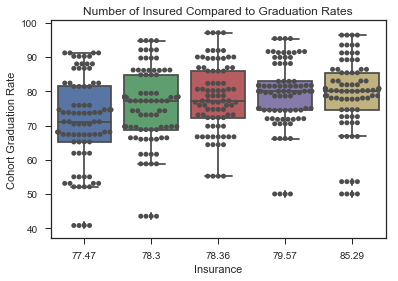

In [289]:
sns.set(style='ticks')
sns.boxplot(y='Cohort Graduation Rate', x='Insurance',data=m5)
sns.swarmplot(y='Cohort Graduation Rate', x='Insurance', data=m5, size=5, color='.3', linewidth=0)
plt.title('Number of Insured Compared to Graduation Rates')
plt.show()

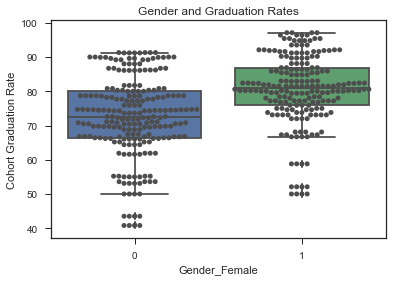

In [290]:
sns.set(style='ticks')

sns.boxplot(x='Gender_Female', y='Cohort Graduation Rate', data=m5)

sns.swarmplot(x='Gender_Female', y='Cohort Graduation Rate', data=m5, size=5, color='.3', linewidth=0)

plt.title('Gender and Graduation Rates')

plt.show()

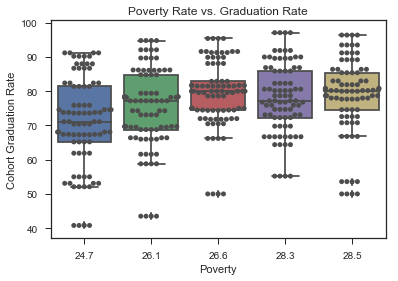

In [291]:
sns.set(style='ticks')

sns.boxplot(x='Poverty', y='Cohort Graduation Rate', data=m5)

sns.swarmplot(x='Poverty', y='Cohort Graduation Rate', data=m5, size=5, color='.3', linewidth=0)

plt.title('Poverty Rate vs. Graduation Rate')

plt.show()


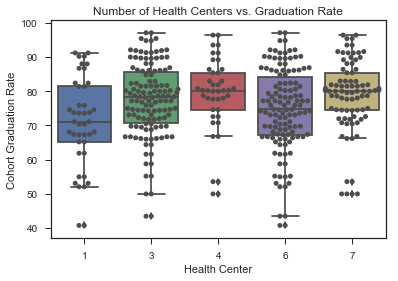

In [292]:
sns.set(style='ticks')

sns.boxplot(x='Health Center', y='Cohort Graduation Rate', data=m5)

sns.swarmplot(x='Health Center', y='Cohort Graduation Rate', size=5, color='.3', linewidth=0, data=m5)

plt.title('Number of Health Centers vs. Graduation Rate')

plt.show()